In [1]:
import os
import csv
import numpy as np
import pandas as pd
from itertools import chain,cycle
from scipy.stats import linregress,gaussian_kde
import corner

import thesis_tools

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import Normalize

import seaborn as sb
blue=sb.xkcd_palette(['windows blue'])[0]
amber=sb.xkcd_palette(['amber'])[0]
red=sb.xkcd_palette(['pale red'])[0]

% matplotlib inline

plt.style.use('sm')

In [2]:
with open('primary_sightlines.csv','r') as csvfile:
    inp=csv.reader(csvfile)
    primary_sightlines=next(inp)

sl_data=thesis_tools.load_data(primary_sightlines)
all_data=thesis_tools.load_results(sl_data)

/Users/codydirks/python/thesis_tools/loaders.py:105: RuntimeWarning: divide by zero encountered in log10
  n_dict[ion]=round(np.log10(n_tot),3)
/Users/codydirks/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/codydirks/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/codydirks/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/codydirks/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/codydirks/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarni

In [3]:
sheffer_data=pd.read_csv('sheffer_co_h2.csv')
burgh_data=pd.read_csv('burgh_data.csv')

# Compiles the Jenkins f1,f2 data
jenkins_c_data=pd.read_csv('jenkins_c_table.txt',header=23)
jenkins_c_data['C*']=np.log10(jenkins_c_data['f1']*jenkins_c_data['N(CIt)'])
jenkins_c_data['C**']=np.log10(jenkins_c_data['f2']*jenkins_c_data['N(CIt)'])
jenkins_c_data['C']=np.log10(jenkins_c_data['N(CIt)']-(10**jenkins_c_data['C*']+10**jenkins_c_data['C**']))
jenkins_c_data['N(CIt)']=np.log10(jenkins_c_data['N(CIt)'])
jenkins_c_data=jenkins_c_data.rename(index=str, columns={"N(CIt)": "Ctot", "Name": "Sightline", "Vel":"Velocity"})
jenkins_c_data=jenkins_c_data[['Sightline','Velocity','C','C*','C**','Ctot','f1','e_f1','f2','e_f2']]

jenkins_table3=pd.read_csv('jenkins_table3.csv')

# Gets elemental depletion parameters from Jenkins09 Table 4
epcols=['Ax','Bx','zx']
element_params=pd.read_csv('jenkins_table4.csv')
element_params[epcols]=element_params[epcols].apply(pd.to_numeric)
element_params['El']=pd.Series([x.strip() for x in element_params['El']])

/Users/codydirks/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
/Users/codydirks/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/Users/codydirks/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


/Users/codydirks/anaconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/codydirks/anaconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


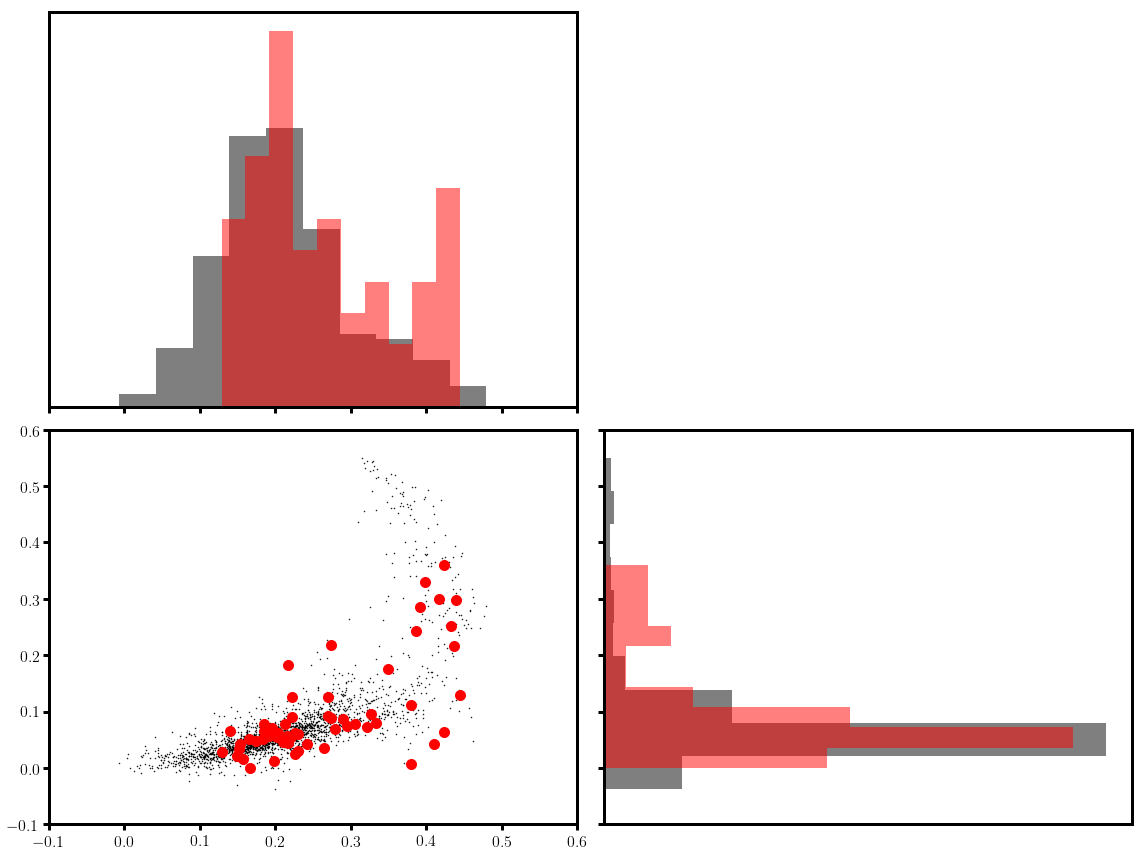

In [4]:
gs=gridspec.GridSpec(2,2)
fig=plt.figure(1,figsize=(16,12),facecolor='w')
subplt1=plt.subplot(gs[0])
subplt2=plt.subplot(gs[2])
subplt3=plt.subplot(gs[3])
subplts=[subplt1,subplt2,subplt3]
norm=Normalize(vmin=12,vmax=17)
x = jenkins_c_data['f1']
y = jenkins_c_data['f2']
xmin, xmax = -0.1, 0.6
ymin, ymax = -0.1, 0.6

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

#subplt2.contour(xx, yy, f, 100,cmap='viridis',alpha=0.2,zorder=1)
subplt2.plot(x,y,'ko',markersize=0.5,zorder=1)
subplt2.set_xlim(xmin,xmax)
subplt2.set_ylim(ymin,ymax)

f1s=[]
f2s=[]

cut_data=all_data[(all_data['C']>0)&(all_data['C*']>0)&(all_data['C**']>0)]
#for sl in cut_data.groupby('Sightline'):
    #Get strongest CO component for each sightline
#    row=sl[1].sort_values('CO',ascending=False).iloc[0]
    
for idx,row in cut_data.iterrows():
    Ctot=10.**row['C']+10.**row['C*']+10.**row['C**']
    f1=(10**row['C*'])/Ctot
    f2=(10**row['C**'])/Ctot
    f1s.append(f1)
    f2s.append(f2)
    sc=subplt2.scatter(f1,f2,
                   c='r',vmin=11,vmax=16.5,cmap='viridis',marker='o',s=100,zorder=2)
    #subplt2.text((10**row['C*'])/Ctot,(10**row['C**'])/Ctot,row['Sightline'])
    
#inset1=inset_axes(subplt2,width='3%',height='75%',loc=2)
#plt.colorbar(sc,cax=inset1)
    
subplt1.hist(x,bins=10,normed=True,alpha=0.5,color='k')
subplt1.hist(f1s,bins=10,normed=True,alpha=0.5,color='r')
subplt1.set_xlim(xmin,xmax)
subplt1.tick_params(labelbottom='off')
subplt1.get_yaxis().set_visible(False)

subplt3.hist(y,bins=10,normed=True,alpha=0.5,orientation='horizontal',color='k')
subplt3.hist(f2s,bins=10,normed=True,alpha=0.5,orientation='horizontal',color='r')
subplt3.set_ylim(ymin,ymax)
subplt3.tick_params(labelleft='off')
subplt3.get_xaxis().set_visible(False)
plt.tight_layout()
#plt.colorbar(sc)

Text(0.2,0.4,'Non-PGCC')

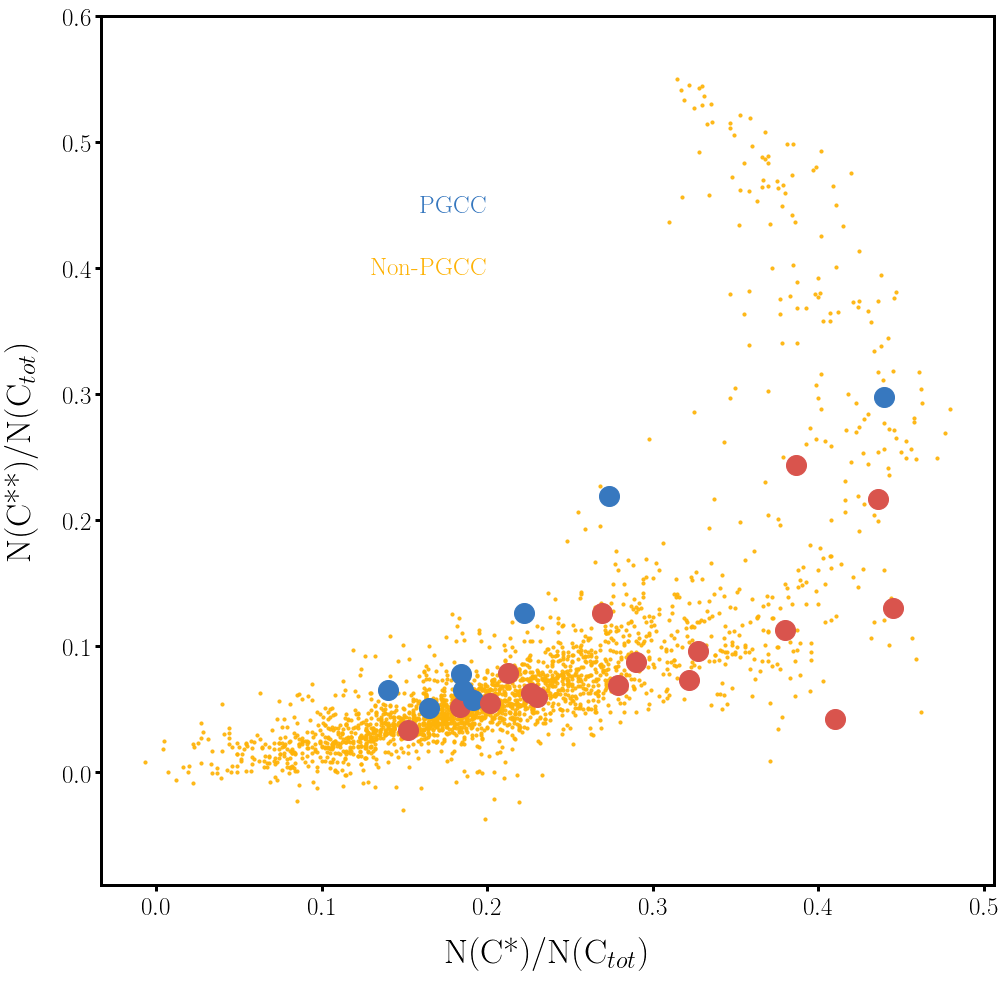

In [5]:
# Standard Jenkins Carbon f1 vs. f2 plot

fig=plt.figure(1,figsize=(16,16),facecolor='w')
subplt=plt.subplot(111)

xmin, xmax = -0.1, 0.53
ymin, ymax = -0.1, 0.6
#subplt.set_xlim(0.2*xmin,xmax)
subplt.set_ylim(0.9*ymin,ymax)

x = jenkins_c_data['f1']
y = jenkins_c_data['f2']
subplt.scatter(x,y,marker='o',color=amber,alpha=0.9,s=10,zorder=1)

f1s=[]
f2s=[]

cut_data=all_data[(all_data['C']>0)&(all_data['C*']>0)&(all_data['C**']>0)&(all_data['CO']>0)]
for sl,data in cut_data.groupby('Sightline'):
    #Get strongest CO component for each sightline
    row=data.sort_values('CO',ascending=False).iloc[0]
    
    # Plot all components
    #subplt.scatter(10**(data['C*']-np.log10((10**data[['C','C*','C**']]).sum(axis=1))),
    #               10**(data['C**']-np.log10((10**data[['C','C*','C**']]).sum(axis=1))),
    #               marker='o',color=blue,s=100)
    
    # Plot sightline-integrated value
    c=row['C']#np.log10(np.sum(10**data[['C']].values))
    c1=row['C*']#np.log10(np.sum(10**data[['C*']].values))
    c2=row['C**']#np.log10(np.sum(10**data[['C**']].values))
    c_tot=np.log10((10**np.array([c,c1,c2])).sum())
    col=blue
    if row['CO']<15:
        col=red
    subplt.plot(10**(c1-c_tot),10**(c2-c_tot),marker='o',color=col,markersize=20)

    
    
subplt.tick_params(axis='both', which='major', labelsize=25)
subplt.set_ylabel('N(C**)/N(C$_{tot}$)',fontsize=35,labelpad=20)
subplt.set_xlabel('N(C*)/N(C$_{tot}$)',fontsize=35,labelpad=20)

subplt.text(0.2,0.45,'PGCC',fontsize=25,weight='bold',verticalalignment='center',horizontalalignment='right',color=blue)
subplt.text(0.2,0.4,'Non-PGCC',fontsize=25,weight='bold',verticalalignment='center',horizontalalignment='right',color=amber)

#plt.savefig('/Users/codydirks/Dropbox/Thesis/Thesis/figures/carbon_pressures.png')

NameError: name 'calc_f' is not defined

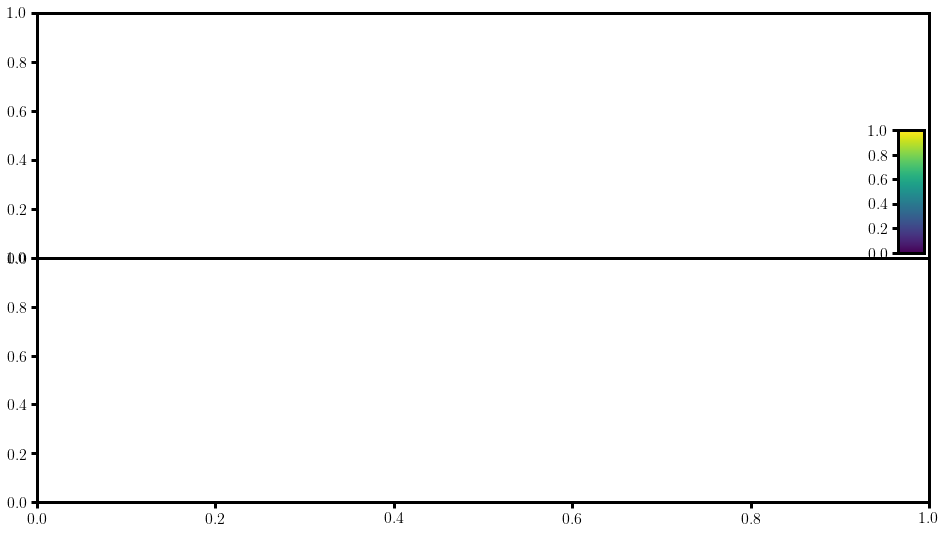

In [6]:
fig,(subplt1,subplt2) = plt.subplots(2, sharex=True,sharey=True,figsize=(16,9))
plt.subplots_adjust(hspace=0)

els=['Ni','O','Ge']
el1='Ni'

norm=Normalize(vmin=0.0,vmax=1.0)
subpltins=inset_axes(subplt1,width='3%',height='50%',loc=4)
cb=mpl.colorbar.ColorbarBase(subpltins,cmap=plt.cm.viridis,norm=norm,ticks=[0.0,0.2,0.4,0.6,0.8,1.0])
subpltins.yaxis.set_ticks_position('left')

for sl,data in all_data.groupby('Sightline'):
    r=data.iloc[0]['R_dist']
    row=data.sort_values('CO',ascending=False).iloc[0]
    
    # Sums various parameters over the entire sightline
    c=np.log10(np.sum(10**data['C']))
    c1=np.log10(np.sum(10**data['C*']))
    c2=np.log10(np.sum(10**data['C**']))
    ctot=np.log10(np.sum(10**c+10**c1+10**c2))
    fh2=2*np.sum(10**data['H_2'])/np.sum(10**data['H_tot'])
    f1=10**(c1-ctot)
    f2=10**(c2-ctot)
    
    f_vals=np.empty(0)
    f_errs=np.empty(0)
    el1param=element_params[element_params['El']==el1].iloc[0]
    for el2 in [y for y in els if y != el1]:
        if row[el2]>0:
            el2param=element_params[element_params['El']==el2].iloc[0]
            f,f_err=calc_f(el1param,el2param,row[el1],row[el2],row[el1+'_err'],row[el2+'_err'])
            f_vals=np.concatenate([f_vals,[f]])
            f_errs=np.concatenate([f_errs,[f_err]])
    f=np.mean(f_vals)
    f_err=np.sqrt(np.sum(f_errs**2))
    
    if fh2<=0.1:
        col='r'
    elif 0.1<fh2<0.5:
        col=blue
    else:
        col='g'
    col=plt.cm.viridis(norm(fh2))
    
    cos_to_sum=all_data[all_data['Sightline']==sl]
    co_sum=np.log10(np.sum([10**n for n in cos_to_sum['CO']]))
    co_sum_err=0.434*np.sqrt(np.sum([10**(2*n) for n in cos_to_sum['CO_err']]))/(10**(co_sum))
    
    cs_to_sum=all_data[all_data['Sightline']==sl]
    cs=[np.log10(np.sum([10**row[c] for c in ('C','C*','C**')])) for idx,row in cs_to_sum.iterrows()]
    c_errs=list(chain.from_iterable([list(row) for idx,row in cs_to_sum[['C_err','C*_err','C**_err']].iterrows()]))
    c_sum=np.log10(np.sum([10**n for n in cs]))
    c_sum_err=0.434*np.sqrt(np.sum([10**(2*n) for n in c_errs]))/(10**c_sum)
    if c_sum_err>1:
        c_sum_err=0.1
    
    if co_sum_err>0.2:
        subplt1.errorbar(10**c_sum,10**co_sum,yerr=0.1*10**co_sum,uplims=True,color=col,markersize=15,zorder=-1)
    else:
        subplt1.errorbar(10**c_sum,10**co_sum,xerr=c_sum_err*10**c_sum,yerr=co_sum_err*10**co_sum,marker='o',color=col,markersize=10,zorder=-1)
    #subplt1.text(c_sum,co_sum,sl)
    
for idx,row in burgh_data.iterrows():
    #if row['Sightline'] not in all_data['Sightline'].unique():
    if row['CO'].startswith('<'):
        co=float(row['CO'][1:])
        cI=float(row['CI'])
        subplt2.errorbar(10**cI,10**co,yerr=0.1*10**co, uplims=True,color='k',marker='o',markersize=4)
    else:
        subplt2.plot(10**float(row['CI']),10**float(row['CO']),marker='o',color='k',markersize=12)


tx=np.arange(13.1,16.1,0.1)
for rat in (0.01,0.1,1,10):
    ty=np.array([np.log10(rat*(10**x)) for x in tx])
    #subplt1.plot(tx,ty,'k--')
    #subplt1.text(tx[-1],ty[-1]-0.04,str(rat),fontsize=25,ha='right',va='bottom',rotation=23)

#subplt2.text(15.75,11.8,'\\textbf{Burgh}',ha='right',va='bottom',color='k',fontsize=35)
subplt2.set_xlabel('C \\textsc{i}')
subplt1.set_ylabel('CO')
subplt2.set_ylabel('CO')
#subplt1.set_xlim(13.2,15.8)
#subplt1.set_ylim(11.5,16.8)
subplt1.set_title('C vs. CO (Integrated)',fontsize=30)
subplt1.set_xscale('log')
subplt1.set_yscale('log')
subplt2.set_yscale('log')

subplt1.text(.995,0.54,'f$_{H_2}$',transform=subplt1.transAxes,fontsize=30,ha='right',va='bottom')
#subplt1.plot(0.96,0.05,marker='o',color='r',markersize=12,alpha=0.9,transform=subplt1.transAxes)
#subplt1.plot(0.96,0.145,marker='o',color=blue,markersize=12,alpha=0.9,transform=subplt1.transAxes)
#subplt1.plot(0.96,0.235,marker='o',color='g',markersize=12,alpha=0.9,transform=subplt1.transAxes)
#subplt1.text(0.94,0.05,'$<0.1$',transform=subplt1.transAxes,color='k',fontsize=25,ha='right',va='center')
#subplt1.text(0.94,0.145,'$0.1-0.5$',transform=subplt1.transAxes,color='k',fontsize=25,ha='right',va='center')
#subplt1.text(0.94,0.235,'$>0.5$',transform=subplt1.transAxes,color='k',fontsize=25,ha='right',va='center')


#plt.savefig('/Users/codydirks/Desktop/plots/c_vs_co_vs_fh2_continuous.pdf')

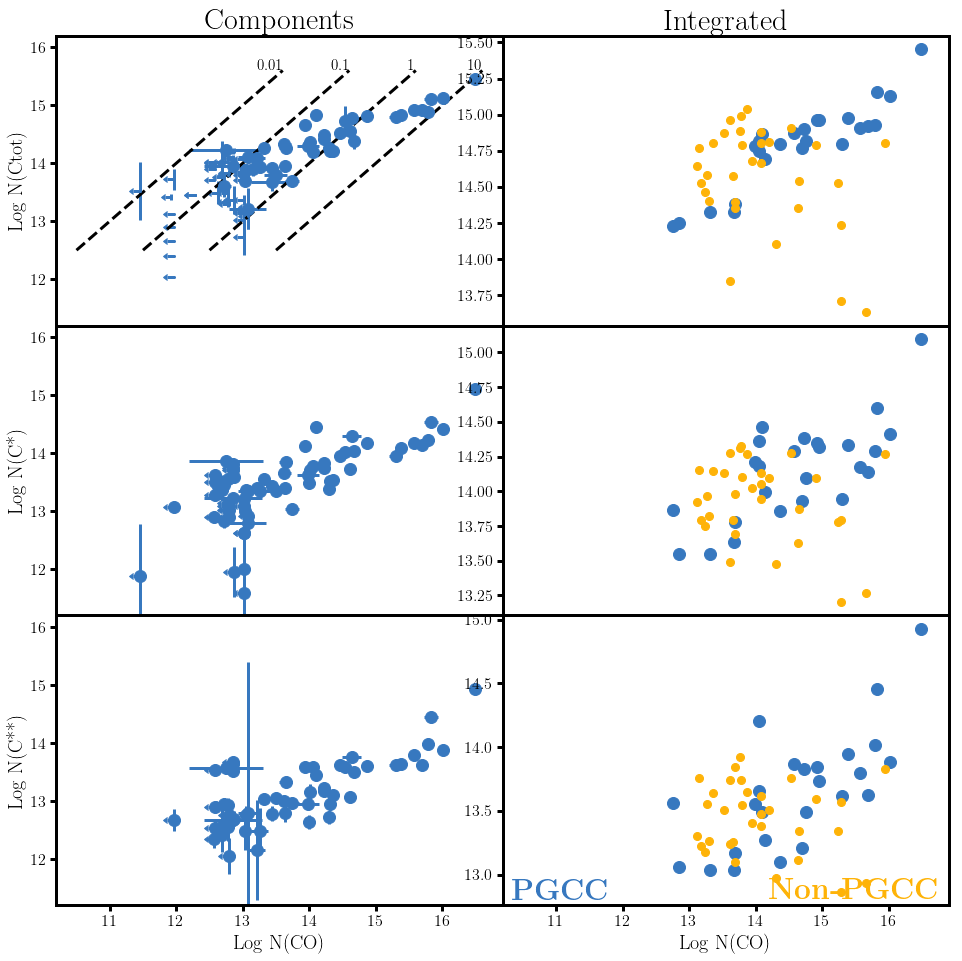

In [9]:
fig,((subplt1,subplt2),
     (subplt3,subplt4),
     (subplt5,subplt6)) = plt.subplots(nrows=3,ncols=2, sharex=True,sharey=False,figsize=(16,16))
plt.subplots_adjust(hspace=0,wspace=0)

cut_data=all_data[(all_data['C']>0)]
for sl,data in cut_data.groupby('Sightline'):
    for idx,row in data.iterrows():
        ctot_sum=np.log10(np.sum([10**row[col] for col in ('C','C*','C**')]))
        c_err=0.434*np.sum([10**row[col+'_err'] for col in ('C','C*','C**')])/10**ctot_sum
        if c_err>10:
            c_err=0.5
        if row['CO']<10:
            x=row['CO_err']
            xerr=0.1
            xuplims=True
            ms=2
        else:
            x=row['CO']
            xerr=0.434*(10**(row['CO_err']-row['CO']))
            xuplims=False
            ms=12
        subplt1.errorbar(x,ctot_sum,xerr=xerr,yerr=c_err,
                         xuplims=xuplims,color=blue,marker='o',markersize=ms)
        for subplt,ion in ((subplt3,'C*'),(subplt5,'C**')):
            if row[ion]<10:
                y=10**(row[ion+'_err']-ctot_sum)
                yerr=0.1
                yuplims=True
                ms=2
            else:
                y=(row[ion])
                #yerr=y*np.sqrt(10**(2*(row[ion+'_err']-row[ion]))+10**(2*(c_err-ctot_sum)))
                yerr=0.434*(10**(row[ion+'_err']-row[ion]))
                yuplims=False
                ms=12
            subplt.errorbar(x,y,xerr=xerr,yerr=yerr, 
                             xuplims=xuplims,uplims=yuplims,color=blue,marker='o',markersize=ms)
        
    cos_to_sum=all_data[all_data['Sightline']==sl]
    co_sum=np.log10(np.sum([10**n for n in cos_to_sum['CO']]))
    co_sum_err=0.434*np.sqrt(np.sum([10**(2*n) for n in cos_to_sum['CO_err']]))/(10**(co_sum))
    subplt2.plot(co_sum,np.log10(np.sum([np.sum(10**data[x]) for x in ('C','C*','C**')])),marker='o',color=blue,ms=12)
    subplt4.plot(co_sum,np.log10(np.sum(10**data['C*'])),marker='o',color=blue,markersize=12)
    subplt6.plot(co_sum,np.log10(np.sum(10**data['C**'])),marker='o',color=blue,markersize=12)


    
subplt1.set_ylabel('Log N(Ctot)')
subplt3.set_ylabel('Log N(C*)')
subplt5.set_ylabel('Log N(C**)')
subplt1.set_ylim(11.2,16.2)
subplt3.set_ylim(11.2,16.2)
subplt5.set_ylim(11.2,16.2)
    
    
for sl in list(set(sheffer_data['#Sightline'].unique()).intersection(set(jenkins_c_data['Sightline']))):
    sheffer=sheffer_data[sheffer_data['#Sightline']==sl]
    jenkins=jenkins_c_data[jenkins_c_data['Sightline']==sl]
    ctotsum=np.log10(np.sum(10**jenkins['Ctot']))
    c1sum=np.log10(np.sum(10**jenkins['C*']))
    c2sum=np.log10(np.sum(10**jenkins['C**']))
    subplt2.plot(sheffer['CO'],ctotsum,marker='o',color=amber,markersize=8)
    subplt4.plot(sheffer['CO'],c1sum,marker='o',color=amber,markersize=8)
    subplt6.plot(sheffer['CO'],c2sum,marker='o',color=amber,markersize=8)
    
subplt5.set_xlabel('Log N(CO)')
subplt6.set_xlabel('Log N(CO)')
#subplt3.set_ylim(12,15.3)
subplt1.set_title('Components',fontsize=30)
subplt2.set_title('Integrated',fontsize=30)

subplt6.text(0.02,0.02,'\\textbf{PGCC}',color=blue,fontsize=30,ha='left',transform=subplt6.transAxes)
subplt6.text(0.98,0.02,'\\textbf{Non-PGCC}',color=amber,fontsize=30,ha='right',transform=subplt6.transAxes)

ty=np.arange(12.5,15.7,0.1)
for rat in (0.01,0.1,1,10):
    tx=np.array([np.log10(rat*(10**y)) for y in ty])
    subplt1.plot(tx,ty,'k--')
    subplt1.text(tx[-1],ty[-1],str(rat),fontsize=15,ha='right')